# LSTM Pipeline for Racing Line Prediction

In [1]:
# Quick check to ensure model will run on GPU
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

2.6.0+cu126
CUDA available: True
Device: NVIDIA GeForce GTX 1080


In [2]:
# === Imports ===
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])
import matplotlib.pyplot as plt

In [3]:
# === Configuration ===

# First Run Config
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 23,
#     "train_split": 0.8,
#     "num_epochs": 50,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "hidden_size": 128,
#     "num_layers": 2,
#     "dropout": 0.2,
#     "seq_len": 50,
#     "patience": 10,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","length","id","speed","gas","brake","obsolete_lat_g","radius","side_left","side_right","camber",
#                     "direction","normal_x","normal_y","normal_z","extra_length","forward_x","forward_y","forward_z","tag","grade"]
# }

# Long Run Config
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 23,
#     "train_split": 0.8,
#     "num_epochs": 200,
#     "learning_rate": 0.0005,
#     "batch_size": 64,
#     "hidden_size": 512,
#     "num_layers": 4,
#     "dropout": 0.1,
#     "seq_len": 50,
#     "patience": 25,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/seven_feat_racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","length","id","speed","gas","brake","obsolete_lat_g","radius","side_left","side_right","camber",
#                     "direction","normal_x","normal_y","normal_z","extra_length","forward_x","forward_y","forward_z","tag","grade"]
# }

# Less target features still big model but less epochs
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 7,
#     "train_split": 0.8,
#     "num_epochs": 50,
#     "learning_rate": 0.0005,
#     "batch_size": 64,
#     "hidden_size": 512,
#     "num_layers": 4,
#     "dropout": 0.1,
#     "seq_len": 50,
#     "patience": 25,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/seven_feat_racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","gas","brake","side_left","side_right"]
# }

#Testing config
config = {
    "model_type": "lstm", # Options: "lstm", "cnn", "tcn", "transformer" 
    "seed": 42,
    "input_size": 6,
    "output_size": 3,
    "train_split": 0.8,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "batch_size": 64,
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "seq_len": 150,
    "patience": 10,
    "pin_memory": True,
    "bidirectional": False,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "train_data_path": "./data/extracted_track_data/",
    "test_data_path": "./data/testing_layouts/",
    "model_save_path": "./models/mucho_data_racing_line_lstm.pt",
    "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
    "output_cols": ["x","y","z"]
}

In [4]:
# === Dataset ===
class RacingLineDataset(Dataset):
    def __init__(self, config):
        self.inputs, self.targets = [], []
        self.seq_len = config["seq_len"]
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        all_X, all_Y = [], []
        train_files = sorted(glob(os.path.join(config["train_data_path"], "*.csv")))
        test_files = sorted(glob(os.path.join(config["test_data_path"], "*.csv")))

        # === First pass: Collect data for global fitting ===
        for file in train_files:
            df = pd.read_csv(file)
            X = df[config["input_cols"]].values
            Y = df[config["output_cols"]].values
            all_X.append(X)
            all_Y.append(Y)
        for file in test_files:
            df = pd.read_csv(file)
            X = df[config["input_cols"]].values
            Y = df[config["output_cols"]].values
            all_X.append(X)
            all_Y.append(Y)
        all_X = np.vstack(all_X)
        all_Y = np.vstack(all_Y)
        self.scaler_x.fit(all_X)
        self.scaler_y.fit(all_Y)

        # === Second pass: Normalize and extract sequences ===
        for file in train_files:
            df = pd.read_csv(file)
            X = self.scaler_x.transform(df[config["input_cols"]].values)
            Y = self.scaler_y.transform(df[config["output_cols"]].values)

            for i in range((len(X) - self.seq_len) + 1):
                self.inputs.append(X[i:i+self.seq_len])
                self.targets.append(Y[i+self.seq_len-1])

        # Convert to tensors
        self.inputs = torch.tensor(np.array(self.inputs), dtype=torch.float32)
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    

In [5]:
# === Model with Attention ===
class RacingLineLSTMWithAttention(nn.Module):
    def __init__(self, config, scaler_x=None, scaler_y=None):
        super().__init__()
        self.bidirectional = config["bidirectional"]
        self.hidden_size = config["hidden_size"]
        self.num_directions = 2 if self.bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=config["input_size"],
            hidden_size=self.hidden_size,
            num_layers=config["num_layers"],
            dropout=config["dropout"],
            batch_first=True,
            bidirectional=self.bidirectional
        )

        self.attn = nn.Linear(self.num_directions * self.hidden_size, 1)
        self.dropout = nn.Dropout(config["dropout"])
        self.fc = nn.Linear(self.num_directions * self.hidden_size, config["output_size"])

        # Optional scalers for external inference use
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

    def forward(self, x):
        lstm_out, _ = self.lstm(x) # x: (batch, seq_len, input_size)
        attn_scores = self.attn(lstm_out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

    def get_attention_weights(self, x):
        """Optional: for visualization/debugging"""
        lstm_out, _ = self.lstm(x)
        attn_scores = self.attn(lstm_out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        return attn_weights.squeeze(-1)  # (batch, seq_len)
    

In [6]:
# Some other basic models to try (needs testing)

#=======================================================================================
# 1D CNN
class RacingLineCNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(config["input_size"], 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, config["output_size"])
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # CNN expects [Batch size, Channels (features), Time (sequence length)]
        return self.net(x)

#=======================================================================================
# Temporal Convolutional Network
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_ch, out_ch, kernel_size, stride, padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.block(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class RacingLineTCN(nn.Module):
    def __init__(self, config, levels=3, kernel_size=3):
        super().__init__()
        layers = []
        in_ch = config["input_size"]
        for i in range(levels):
            out_ch = 64 * (2 ** i)
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, 1, dilation, padding, config["dropout"]))
            in_ch = out_ch
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(in_ch, config["output_size"])

    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.network(x)
        out = out[:, :, -1]
        return self.linear(out)

#=======================================================================================
# Transformer Model
class RacingLineTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Linear(config["input_size"], config["hidden_size"])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config["hidden_size"],
            nhead=4,
            dropout=config["dropout"],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config["num_layers"])
        self.fc = nn.Linear(config["hidden_size"], config["output_size"])

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1])
    
#=======================================================================================
# GNN/GCN (an idea to try if we desire)



In [7]:
# === Model Selector ===
def get_model(config, scaler_x=None, scaler_y=None):
    match config["model_type"]:
        case "lstm":
            return RacingLineLSTMWithAttention(config, scaler_x=scaler_x, scaler_y=scaler_y)
        case "cnn":
            return RacingLineCNN(config)
        case "tcn":
            return RacingLineTCN(config)
        case "transformer":
            return RacingLineTransformer(config)
        case _:
            raise ValueError(f"Unknown model type: {config['model_type']}")
        

In [8]:
# === Evaluation/Loss Functions ===
def hybrid_loss(preds, targets, alpha=0.9):
    euclidean = torch.norm(preds - targets, dim=1).mean()
    cosine = 1 - F.cosine_similarity(preds, targets, dim=1).mean()
    return alpha * euclidean + (1 - alpha) * cosine

def evaluate_model(model, dataloader, criterion, config):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch, in dataloader:
            X_batch, Y_batch = X_batch.to(config["device"]), Y_batch.to(config["device"])
            if config["model_type"] in ["cnn", "tcn"]: X_batch = X_batch.permute(0,2,1)
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [9]:
# === Save and Load Model (with architecture) ===
def save_model(model, config, scaler_x, scaler_y):
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
    }, config["model_save_path"])

# def load_model(path):
#     checkpoint = torch.load(path, map_location=config["device"], weights_only=False)
#     cfg = checkpoint["config"]
#     model = RacingLineLSTMWithAttention(cfg["input_size"], cfg["hidden_size"],
#                                         cfg["output_size"], cfg["num_layers"],
#                                         cfg["dropout"], cfg["bidirectional"])
#     model.load_state_dict(checkpoint["model_state_dict"])
#     model.to(cfg["device"])
#     return model, checkpoint["scaler_x"], checkpoint["scaler_y"]

def load_model(path, config):
    checkpoint = torch.load(path, map_location=config["device"], weights_only=False)
    cfg = checkpoint["config"]
    model = get_model(cfg)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(cfg["device"])
    scaler_x = checkpoint["scaler_x"]
    scaler_y = checkpoint["scaler_y"]
    return model, scaler_x, scaler_y


In [10]:
# === Training Function (with tqdm and validation) ===
def train_model(model, train_loader, val_loader, config, scaler_x, scaler_y):
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = hybrid_loss #nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    early_stopping_patience = config["patience"]
    epochs_without_improvement = 0
    best_epoch = 0

    obar = tqdm(range(config["num_epochs"]), desc="Epochs")
    for epoch in obar:
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}", leave=False)
        for X_batch, Y_batch, in pbar:
            X_batch, Y_batch = X_batch.to(config["device"]), Y_batch.to(config["device"])
            if config["model_type"] in ["cnn", "tcn"]: X_batch = X_batch.permute(0,2,1)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({"Loss": running_loss / (pbar.n + 1)})

        train_losses.append(running_loss / len(train_loader))
        val_loss = evaluate_model(model, val_loader, criterion, config)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config, scaler_x, scaler_y)
            best_epoch = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        obar.set_postfix({"Train Loss": running_loss/len(train_loader), "Val Loss": val_loss, "Lr": scheduler.get_last_lr()[0], "best_epoch": best_epoch})

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return train_losses, val_losses


In [11]:
# === Full Pipeline ===
def run_pipeline(config):
    random.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("Preparing dataset...")
    full_dataset = RacingLineDataset(config)
    scaler_x = full_dataset.scaler_x
    scaler_y = full_dataset.scaler_y
    print("Total sequences loaded:", len(full_dataset))

    # === 80/20 train/val split with reproducibility ===
    train_len = int(len(full_dataset) * config["train_split"])
    val_len = len(full_dataset) - train_len
    train_ds, val_ds = random_split(
        full_dataset,
        [train_len, val_len],
        generator=torch.Generator().manual_seed(config["seed"])
    )

    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=False, pin_memory=config["pin_memory"])
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, pin_memory=config["pin_memory"])

    print(f"Initializing model: {config["model_type"]}...")
    model = get_model(config=config, scaler_x=scaler_x, scaler_y=scaler_y).to(config["device"])

    print("Training started...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, config, scaler_x, scaler_y)
    print(f"Training complete. Model saved to {config['model_save_path']}")

    # === Plot learning curve ===
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    

Preparing dataset...
Total sequences loaded: 359352
Initializing model: lstm...
Training started...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/4492 [00:00<?, ?it/s]

Training complete. Model saved to ./models/mucho_data_racing_line_lstm.pt


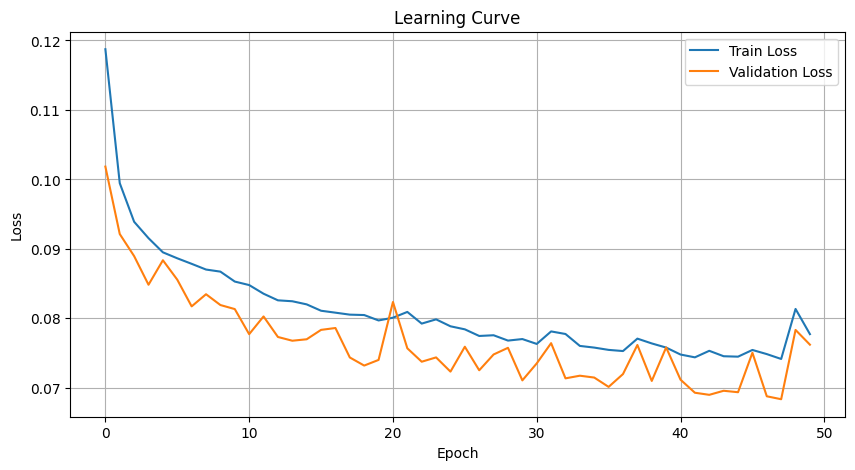

In [12]:
# === Train Model ===
run_pipeline(config)

Loading model and scalers...
Loading unseen layouts from: ./data/testing_layouts
Found 1 layout files.

[1/1] Predicting layout: spa_spa_Processed_Data.csv


[1/1]:   0%|          | 0/4364 [00:00<?, ?it/s]

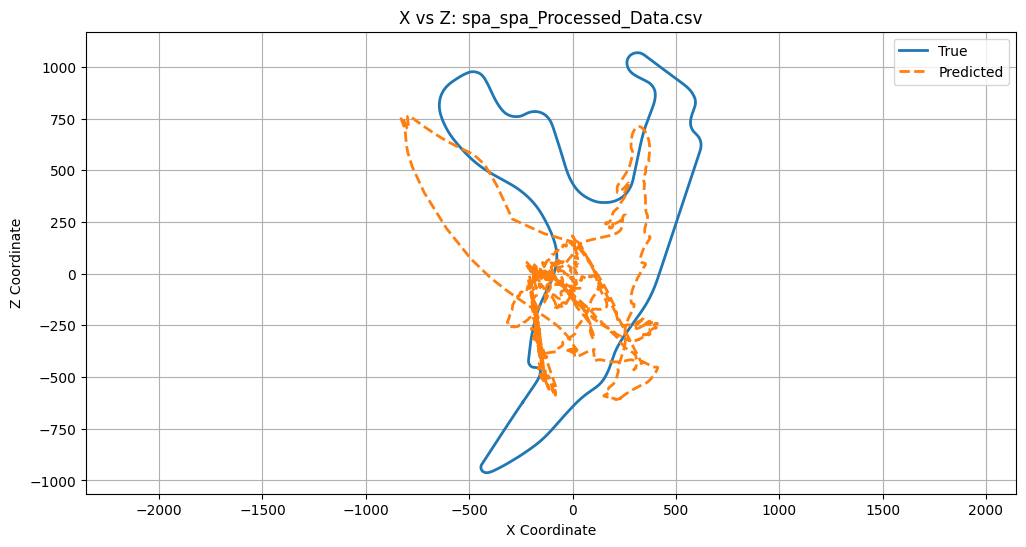


Per-Feature Accuracy (%):
------------------------------------------------------------
               x:  75.53% (layout-based)     0.00% (train-scale)
               y:  71.21% (layout-based)     0.00% (train-scale)
               z:  67.48% (layout-based)     0.00% (train-scale)
Mean X/Z spatial error: 755.41m, Max: 1452.91m



In [17]:
# === Inference on Testing Track Layouts (from coordinates only, doesnt take image for inference) ===
def print_feature_accuracy(preds, trues, scaler_y, feature_names):
    preds = np.array(preds)
    trues = np.array(trues)

    print(f"\nPer-Feature Accuracy (%):")
    print("-" * 60)
    for i, name in enumerate(feature_names):
        range_train = scaler_y.scale_[i]
        range_test = trues[:, i].max() - trues[:, i].min()

        if range_test == 0:
            print(f"{name:>16}: N/A (zero test range)")
            continue

        mean_error = np.mean(np.abs(preds[:, i] - trues[:, i]))
        acc_train = (1 - (mean_error / range_train)) * 100
        acc_test = (1 - (mean_error / range_test)) * 100

        acc_train = max(0.0, min(100.0, acc_train))
        acc_test = max(0.0, min(100.0, acc_test))

        print(f"{name:>16}: {acc_test:6.2f}% (layout-based)   {acc_train:6.2f}% (train-scale)")

# === Circular Tracks ===
def run_inference(config, data_folder, model_path):
    print("Loading model and scalers...")
    model, scaler_x, scaler_y = load_model(model_path, config)
    model.eval()

    print("Loading unseen layouts from:", data_folder)
    layout_files = sorted(glob(os.path.join(data_folder, "*.csv")))
    total_layouts = len(layout_files)
    print(f"Found {total_layouts} layout files.\n")

    for layout_index, layout_path in enumerate(layout_files):
        layout_name = os.path.basename(layout_path)
        print(f"[{layout_index + 1}/{total_layouts}] Predicting layout: {layout_name}")

        df = pd.read_csv(layout_path)
        X = df[config["input_cols"]].values
        Y = df[config["output_cols"]].values
        X_scaled = scaler_x.transform(X)
        n = len(X_scaled)
        preds_real = np.zeros_like(Y)
        trues_real = Y.copy()

        for i in tqdm(range(n), desc=f"[{layout_index + 1}/{total_layouts}]"):
            seq = np.array([X_scaled[(i + j) % n] for j in range(config["seq_len"])])
            X_tensor = torch.tensor(seq.reshape(1, config["seq_len"], -1), dtype=torch.float32).to(config["device"])

            with torch.no_grad():
                pred_scaled = model(X_tensor).cpu().squeeze().numpy()
                pred_real = scaler_y.inverse_transform(pred_scaled.reshape(1, -1))[0]

            target_idx = (i + config["seq_len"]) % n
            preds_real[target_idx] += pred_real

        # === Plot X/Z comparison ===
        plt.figure(figsize=(12, 6))
        plt.plot(trues_real[:, 0], trues_real[:, 2], label="True", linewidth=2)
        plt.plot(preds_real[:, 0], preds_real[:, 2], label="Predicted", linewidth=2, linestyle="--")
        plt.title(f"X vs Z: {layout_name}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Z Coordinate")
        plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.show()

        # === Accuracy ===
        print_feature_accuracy(preds_real, trues_real, scaler_y, config["output_cols"])

        # === Spatial Error (X/Z only)
        spatial_errors = np.linalg.norm(preds_real[:, [0, 2]] - trues_real[:, [0, 2]], axis=1)
        mean_spatial_error = np.mean(spatial_errors)
        max_spatial_error = np.max(spatial_errors)
        print(f"Mean X/Z spatial error: {mean_spatial_error:.2f}m, Max: {max_spatial_error:.2f}m\n")

# === Non-Circular Tracks ===
# def run_inference(config, data_folder, model_path):
#     print("Loading model and scalers...")
#     model, scaler_x, scaler_y = load_model(model_path, config)
#     model.eval()

#     print("Loading unseen layouts from:", data_folder)
#     layout_files = sorted(glob(os.path.join(data_folder, "*.csv")))
#     total_layouts = len(layout_files)
#     print(f"Found {total_layouts} layout files.\n")

#     for layout_index, layout_path in enumerate(layout_files):
#         layout_name = os.path.basename(layout_path)
#         print(f"[{layout_index + 1}/{total_layouts}] Predicting layout: {layout_name}")

#         # === Load layout data ===
#         df = pd.read_csv(layout_path)
#         X = df[config["input_cols"]].values
#         Y = df[config["output_cols"]].values
#         X_scaled = scaler_x.transform(X)
#         n = len(X_scaled)
#         seq_len = config["seq_len"]

#         preds_real = np.zeros_like(Y)
#         trues_real = Y.copy()

#         for i in tqdm(range(n), desc=f"[{layout_index + 1}/{total_layouts}]"):
#             # Pad first `seq_len` frames with the first frame
#             if i < seq_len:
#                 pad = np.repeat(X_scaled[0:1], seq_len - i, axis=0)
#                 seq = np.vstack([pad, X_scaled[0:i]])
#             else:
#                 seq = X_scaled[i - seq_len:i]

#             X_tensor = torch.tensor(seq.reshape(1, seq_len, -1), dtype=torch.float32).to(config["device"])

#             with torch.no_grad():
#                 pred_scaled = model(X_tensor).cpu().squeeze().numpy()
#                 pred_real = scaler_y.inverse_transform(pred_scaled.reshape(1, -1))[0]

#             preds_real[i] = pred_real

#         # === Plotting ===
#         plt.figure(figsize=(12, 6))
#         plt.plot(trues_real[:, 0], trues_real[:, 2], label="True", linewidth=2)
#         plt.plot(preds_real[:, 0], preds_real[:, 2], label="Predicted", linewidth=2, linestyle="--")
#         plt.title(f"X vs Z Trajectory: {layout_name}")
#         plt.xlabel("X Coordinate")
#         plt.ylabel("Z Coordinate")
#         plt.axis("equal")
#         plt.grid(True)
#         plt.legend()
#         plt.show()

#         # === Accuracy report ===
#         print_feature_accuracy(preds_real, trues_real, scaler_y, config["output_cols"])

#         # === Spatial error metrics (just X/Z)
#         spatial_errors = np.linalg.norm(preds_real[:, [0, 2]] - trues_real[:, [0, 2]], axis=1)
#         mean_spatial_error = np.mean(spatial_errors)
#         max_spatial_error = np.max(spatial_errors)
#         print(f"Mean X/Z spatial error: {mean_spatial_error:.2f}m, Max: {max_spatial_error:.2f}m\n")

# === Run it ===
run_inference(config, data_folder="./data/testing_layouts", model_path="./models/mucho_data_racing_line_lstm.pt")
